## Day 13 - Raster

### Data

- Estonian Weatherservice XML ticker

http://www.ilmateenistus.ee/ilma_andmed/xml/observations.php


In [3]:
import requests
import datetime
import xml.etree.ElementTree as ET

import pandas as pd

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import geopandas as gpd
import fiona
from fiona.crs import from_epsg


import numpy as np
from shapely.geometry import Point

import matplotlib.pyplot as plt

%matplotlib inline

req = requests.get("http://www.ilmateenistus.ee/ilma_andmed/xml/observations.php")

print(req.encoding)
print(req.headers['content-type'])

tree = ET.fromstring(req.content.decode(req.encoding) )

print(tree.tag)
print(tree.attrib)

ts = tree.attrib['timestamp']
print(datetime.datetime.fromtimestamp(int(ts)))



ISO-8859-1
text/xml
observations
{'timestamp': '1605625583'}
2020-11-17 17:06:23


106


,stations,wmocode,precipitations,airtemperature,windspeed,waterlevel,watertemperature,geometry
0,Kuressaare linn,None,NaN,9.3,NaN,NaN,NaN,POINT (22.48944444411111 58.26416666666667)
1,Tallinn-Harku,26038,0.1,5.0,4.5,NaN,NaN,POINT (24.60289166662428 59.39812222235513)
2,Pakri,26029,0.1,6.0,4.9,NaN,NaN,POINT (24.04008055547654 59.38950277719013)
3,Kunda,26045,0.0,2.9,5.7,NaN,7.7,POINT (26.54139722207962 59.52141111042325)
4,Jõhvi,26046,0.0,1.4,8.2,NaN,NaN,POINT (27.39827499992098 59.32902499979958)


C:\dev\conda3\envs\geopy2020\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

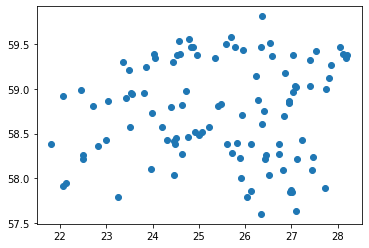

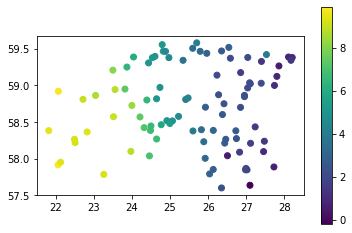

In [4]:
data = {'stations' : [],
        'wmocode': [],
        'precipitations': [],
        'airtemperature': [],
        'windspeed': [],
        'waterlevel': [],
        'watertemperature': [],
        'geometry': []
       }


counter = 0
for station in tree.findall('station'):
    counter += 1
    
    # print(station.tag, child.attrib)
    
    # < name > Virtsu < /name > – jaama nimi.
    name = station.find('name').text
    data['stations'].append(name)
    # < wmocode > 26128 < /wmocode > – jaama WMO kood.
    wmocode = station.find('wmocode').text
    data['wmocode'].append(wmocode)
    
    try:
    # < longitude > 23.51355555534363 < /longitude > – jaama asukoha koordinaat.
        lon = station.find('longitude').text
        # < latitude > 58.572674999100215 < /latitude > – jaama asukoha koordinaat.
        lat = station.find('latitude').text
        coords = Point(float(lon), float(lat))
        data['geometry'].append(coords)
    except ValueError as ve:
        pass
    
    # < phenomenon > Light snowfall < /phenomenon > – jaamas esinev ilmastikunähtus, selle puudumisel pilvisuse aste (kui jaamas tehakse manuaalseid pilvisuse mõõtmisi). Täielik nimekiri nähtustest on allpool olevas tabelis.
    # < visibility > 34.0 < /visibility > – nähtavus (km).
    # < precipitations > 0 < /precipitations > – sademed (mm) viimase tunni jooksul. Lume, lörtsi, rahe ja teiste taoliste sademete hulk on samuti esitatud vee millimeetritena. 1 cm lund ~ 1 mm vett.
    precip = station.find('precipitations').text
    data['precipitations'].append(precip)
    # < airpressure > 1005.4 < /airpressure > – õhurõhk (hPa). Normaalrõhk on 1013.25 hPa.
    # < relativehumidity > 57 < /relativehumidity > – suhteline õhuniiskus (%).
    # < airtemperature > -3.6 < /airtemperature > – õhutemperatuur (°C).
    temp = station.find('airtemperature').text
    data['airtemperature'].append(temp)
    # < winddirection > 101 < /winddirection > – tuule suund (°).
    # < windspeed > 3.2 < /windspeed > – keskmine tuule kiirus (m/s).
    wind = station.find('windspeed').text
    data['windspeed'].append(wind)
    # < windspeedmax > 5.1 < /windspeedmax > – maksimaalne tuule kiirus ehk puhangud (m/s).
    # < waterlevel > -49 < /waterlevel > – veetase (cm Kroonlinna nulli suhtes)
    waterlevel  = station.find('waterlevel').text
    data['waterlevel'].append(waterlevel)
    # < waterlevel_eh2000 > -28 < waterlevel_eh2000/ > – veetase (cm Amsterdami nulli suhtes)
    # waterlevel_eh2000 = station.find('waterlevel_eh2000').text
    # < watertemperature > -0.2 < /watertemperature > – veetemperatuur (°C)
    watertemp = station.find('watertemperature').text
    data['watertemperature'].append(watertemp)

print(counter)

df = pd.DataFrame(data)

for field in ['precipitations','airtemperature','windspeed','waterlevel','watertemperature']:
    if field in df.columns:
        if is_string_dtype(df[field]):
            df[field] = df[field].astype(float)
                
display(df.head(5))

geo_df = gpd.GeoDataFrame(df, crs=from_epsg(4326), geometry='geometry')

geo_df.plot()

air_df = geo_df.dropna(subset=['airtemperature'])

air_df.plot(column='airtemperature', legend=True)

In [5]:
geo_df_3301 = geo_df.dropna(subset=['airtemperature']).to_crs(epsg=3301)
geo_df_3301['x'] = geo_df_3301['geometry'].apply(lambda p: p.x)
geo_df_3301['y'] = geo_df_3301['geometry'].apply(lambda p: p.y)
display(geo_df_3301.head(5))


geo_df_3301.to_file('ilmateenistus_airtemp_stations.shp', encoding='utf-8')

,stations,wmocode,precipitations,airtemperature,windspeed,waterlevel,watertemperature,geometry,x,y
0,Kuressaare linn,None,NaN,9.3,NaN,NaN,NaN,POINT (411346.597 6459155.342),411346.597496,6.459155e+06
1,Tallinn-Harku,26038,0.1,5.0,4.5,NaN,NaN,POINT (534250.544 6584618.823),534250.544367,6.584619e+06
2,Pakri,26029,0.1,6.0,4.9,NaN,NaN,POINT (502277.599 6583505.345),502277.598516,6.583505e+06
3,Kunda,26045,0.0,2.9,5.7,NaN,7.7,POINT (643825.046 6600924.969),643825.045924,6.600925e+06
4,Jõhvi,26046,0.0,1.4,8.2,NaN,NaN,POINT (693367.350 6581666.569),693367.350112,6.581667e+06


### Inverse distance weighting (IDW) to fill a raster

Compute the score of query points based on the scores of their k-nearest neighbours,
weighted by the inverse of their distances.

Author: Paul Brodersen <paulbrodersen+idw@gmail.com>

https://github.com/paulbrodersen/inverse_distance_weighting

In [6]:
import numpy as np

import idw_knn

In [7]:
XY_obs_coords = np.vstack([geo_df_3301['x'].values, geo_df_3301['y'].values]).T
z_arr = geo_df_3301['airtemperature'].values

display(XY_obs_coords.shape)
display(z_arr.shape)

# returns a function that is trained (the tree setup) for the interpolation on the grid
idw_tree = idw_knn.tree(XY_obs_coords, z_arr)

(94, 2)

(94,)

In [8]:
all_dist_m = geo_df_3301['x'].max() - geo_df_3301['x'].min()
dist_km_x = all_dist_m / 1000
display(dist_km_x)

all_dist_m_y = geo_df_3301['y'].max() - geo_df_3301['y'].min()
dist_km_y = all_dist_m_y / 1000
display(dist_km_y)

366.77577143797305

219.85687205510027

In [9]:
# prepare grids
# number of target interpolation grid shape along x and y axis, e.g. 150*100 raster pixels
nx=int(dist_km_x)
ny=int(dist_km_y)

# preparing the "output" grid
x_spacing = np.linspace(geo_df_3301['x'].min(), geo_df_3301['x'].max(), nx)
y_spacing = np.linspace(geo_df_3301['y'].min(), geo_df_3301['y'].max(), ny)

In [10]:
# preparing the target grid
x_y_grid_pairs = np.meshgrid(x_spacing, y_spacing)

x_y_grid_pairs_list = np.reshape(x_y_grid_pairs, (2, -1)).T

display(f"x_y_grid_pairs {len(x_y_grid_pairs)}")
display(f"x_y_grid_pairs_list reshaped {x_y_grid_pairs_list.shape}")

'x_y_grid_pairs 2'

'x_y_grid_pairs_list reshaped (80154, 2)'

In [11]:
# now interpolating onto the target grid
z_arr_interp = idw_tree(x_y_grid_pairs_list)

display(f"z_arr_interp {z_arr_interp.shape}")

'z_arr_interp (80154,)'

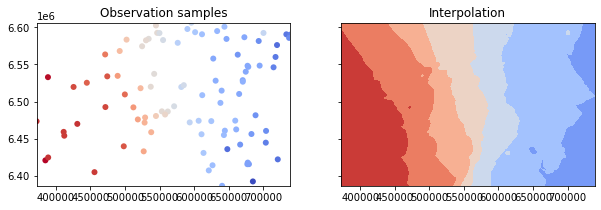

In [15]:
# plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))

ax1.scatter(XY_obs_coords[:,0], XY_obs_coords[:,1], c=geo_df_3301['airtemperature'], cmap='coolwarm', linewidths=0)
ax1.set_title('Observation samples')
ax2.contourf(x_spacing, y_spacing, z_arr_interp.reshape((ny,nx)), cmap='coolwarm')
ax2.set_title('Interpolation')
plt.show()



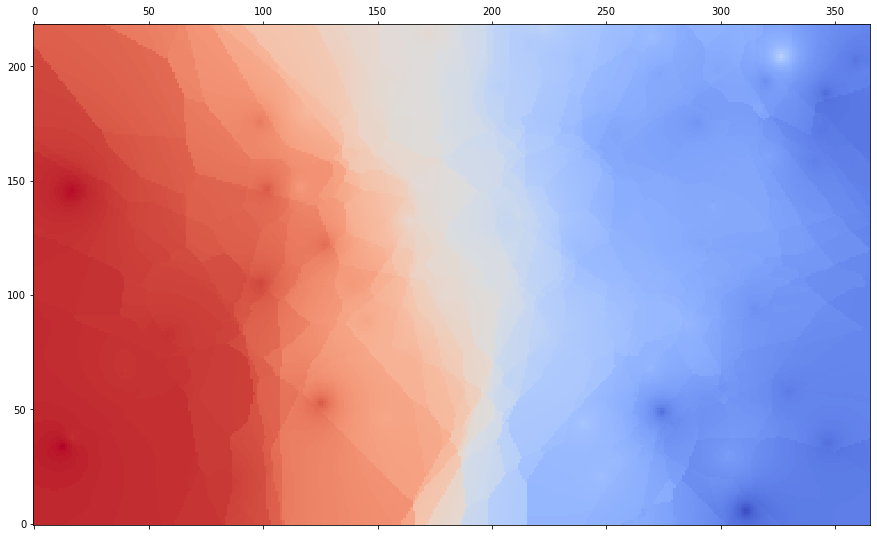

In [29]:
fig, ax = plt.subplots(figsize=(15,11))

ax.matshow(z_arr_interp.reshape((ny,nx)), origin='lower', cmap='coolwarm')

plt.show()

In [18]:
display(f"x_spacing {x_spacing.shape}")
display(f"y_spacing {y_spacing.shape}")

# is a x_y_grid_pair a list of two ndarrays, each is fully spatial 100x150 fields, one holds the x coords the other the y coords
x_mg = np.meshgrid(x_spacing, y_spacing)

display(f"x_mg {type(x_mg)} {len(x_mg)} len0 {type(x_mg[0])} {len(x_mg[0])} {x_mg[0].shape} len1 {type(x_mg[1])} {len(x_mg[1])} {x_mg[0].shape}")

# the yget reshaped into two long flattened arrays the joint full list of target x y pairs representing all grid locations
x_mg_interp_prep = np.reshape(x_mg, (2, -1)).T

display(f"x_mg_interp_prep {type(x_mg_interp_prep)} {len(x_mg_interp_prep)} {x_mg_interp_prep.shape}")

'x_spacing (366,)'

'y_spacing (219,)'

"x_mg <class 'list'> 2 len0 <class 'numpy.ndarray'> 219 (219, 366) len1 <class 'numpy.ndarray'> 219 (219, 366)"

"x_mg_interp_prep <class 'numpy.ndarray'> 80154 (80154, 2)"

### Writing interpolated array to a raster file

In [30]:
from fiona.crs import from_epsg
import pyproj
import osgeo.osr

import gdal
gdal.UseExceptions()

# wkt_projection = CRS("EPSG:3301")
crs = pyproj.Proj(from_epsg(3301))

srs = osgeo.osr.SpatialReference()
srs.ImportFromProj4(crs.srs)
wkt_projection = srs.ExportToWkt()

C:\dev\conda3\envs\geopy2020\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [31]:
#
# KDTree  z_arr_interp
#
ncols = nx
nrows = ny

cell_unit_sizeX = (geo_df_3301['x'].max() - geo_df_3301['x'].min()) / ncols
cell_unit_sizeY = (geo_df_3301['y'].max() - geo_df_3301['y'].min()) / nrows

testnp = z_arr_interp.reshape((ny,nx))

xllcorner = geo_df_3301['x'].min()
xulcorner = geo_df_3301['x'].min()

yllcorner = geo_df_3301['y'].min()
yulcorner = geo_df_3301['y'].max()

nodata_value = -9999

driver = gdal.GetDriverByName("GTiff")

dataset = driver.Create("kdtree_rasterout1.tif", ncols, nrows, 1, gdal.GDT_Float32 )

dataset.SetProjection(wkt_projection)
dataset.SetGeoTransform((xulcorner,cell_unit_sizeX,0,yulcorner,0,-cell_unit_sizeY))

dataset.GetRasterBand(1).WriteArray(np.flipud(testnp))

band = dataset.GetRasterBand(1)
band.SetNoDataValue(nodata_value)

dataset.FlushCache()

# dereference band to avoid gotcha described previously
band = None
dataset = None

In [47]:
est = gpd.read_file(r"C:\dev\05_geodata\dem\countries\estonia_without_lakes.shp")
display(est.crs)

est_g = est.to_crs(3301)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [60]:
import rasterio as rio

src = rio.open('kdtree_rasterout1.tif')

extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

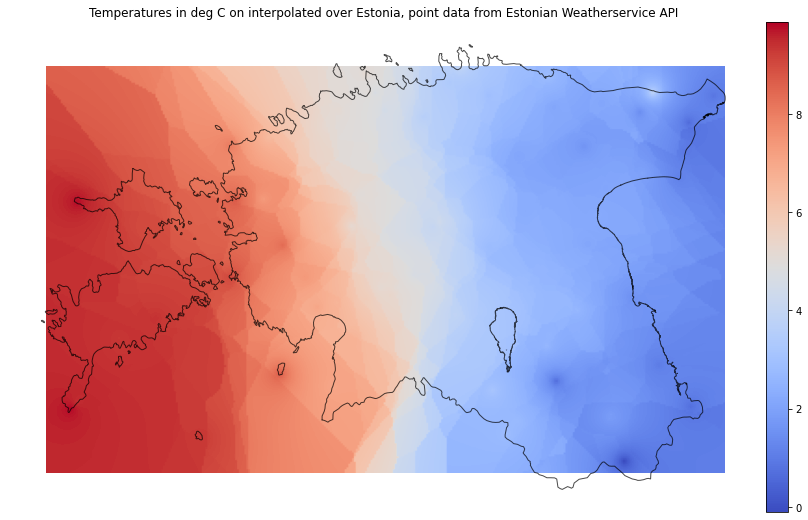

In [63]:
from rasterio.plot import show
import earthpy.plot as ep

fig, ax = plt.subplots(1, figsize=(14, 11))

im = ax.imshow(src.read(1).squeeze(), extent=extent, cmap='coolwarm')
ep.colorbar(im)

est_g.plot(ax=ax, facecolor="none", edgecolor='black', lw=1.0, alpha=0.7)

ax.set(title="Temperatures in deg C on interpolated over Estonia, point data from Estonian Weatherservice API")

ax.set_axis_off()


plt.savefig("../source/_static/day-13-raster.png", bbox_inches='tight')